# Notebook for running 1D-TDSE C code from Python
Author: Tadeas Nemec, 2023

### Load libraries and files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
### Main Python TDSE helper script, contains C structures, function wrappers etc.
from PythonTDSE import *

### Path to compiled dynamic C library
path_to_DLL = os.path.realpath(os.path.join(os.getcwd(), "build/libsingleTDSE.dylib"))

### TDSE DLL class declaration
DLL = TDSE_DLL(path_to_DLL)

### TDSE with custom field

We instantiate a C-compatible ```inputs_def``` class that is in fact C types structure. This strucure (class) contains all the necessary variables for the C 1D-TDSE code. 

We show an example how to run the 1D-TDSE with custom numerical electric provided by the Python high level API.

In [2]:
### Create instance of input structure
inputs = inputs_def()

### Initialize inputs, initialization functions are methods of inputs_def

### First we need to set the default inputs (can be modified with kwargs)
inputs.init_default_inputs()


Initialize temporal grid and initial field. There are two ways how to do it. Either you specify the result file from the CUPRAD code and select a particular field, e.g.:
```Python
# HDF5 file name
filename = "results_CUPRAD.h5"
# Load data from the file name
inputs.load_from_hdf5(filename)
# Set indices of the CUPRAD field
z_i = 75
r_i = 512
# Initialize field and time in the input
inputs.init_time_and_field(DLL, filename, z_i, r_i)
```
or you provide custom electric field and time grids as follows

In [3]:
### Fundamental frequency
omega_0 = 0.057
### Period
T = 2*np.pi/omega_0
### Pulse length
T_max = 5*T
### Number of time points
N_t = int(T_max/inputs.dt) + 1
### Temporal grid
t = np.linspace(0, T_max, N_t)
### Sine squared envelope
sin_2 = lambda t: np.sin(np.pi*t/T_max)**2
### Chirp
chirp = 1e-5*t**2
### Field magnitude
E_0 = 0.05
### Field
E = E_0*sin_2(t)*np.cos(omega_0*t + chirp)

assert(len(E) == len(t))
print("Size of the field and time grids: ", N_t)

Size of the field and time grids:  2205


Initialize time and field into the `inputs` object

In [4]:
inputs.init_time_and_field(DLL, E = E, t = t)

We can visualize and check the fields by plotting.

We use the methods ```get_tgrid()``` and ```get_Efield()``` to obtain numpy arrays with the corresponding data, if saved in the structure. 

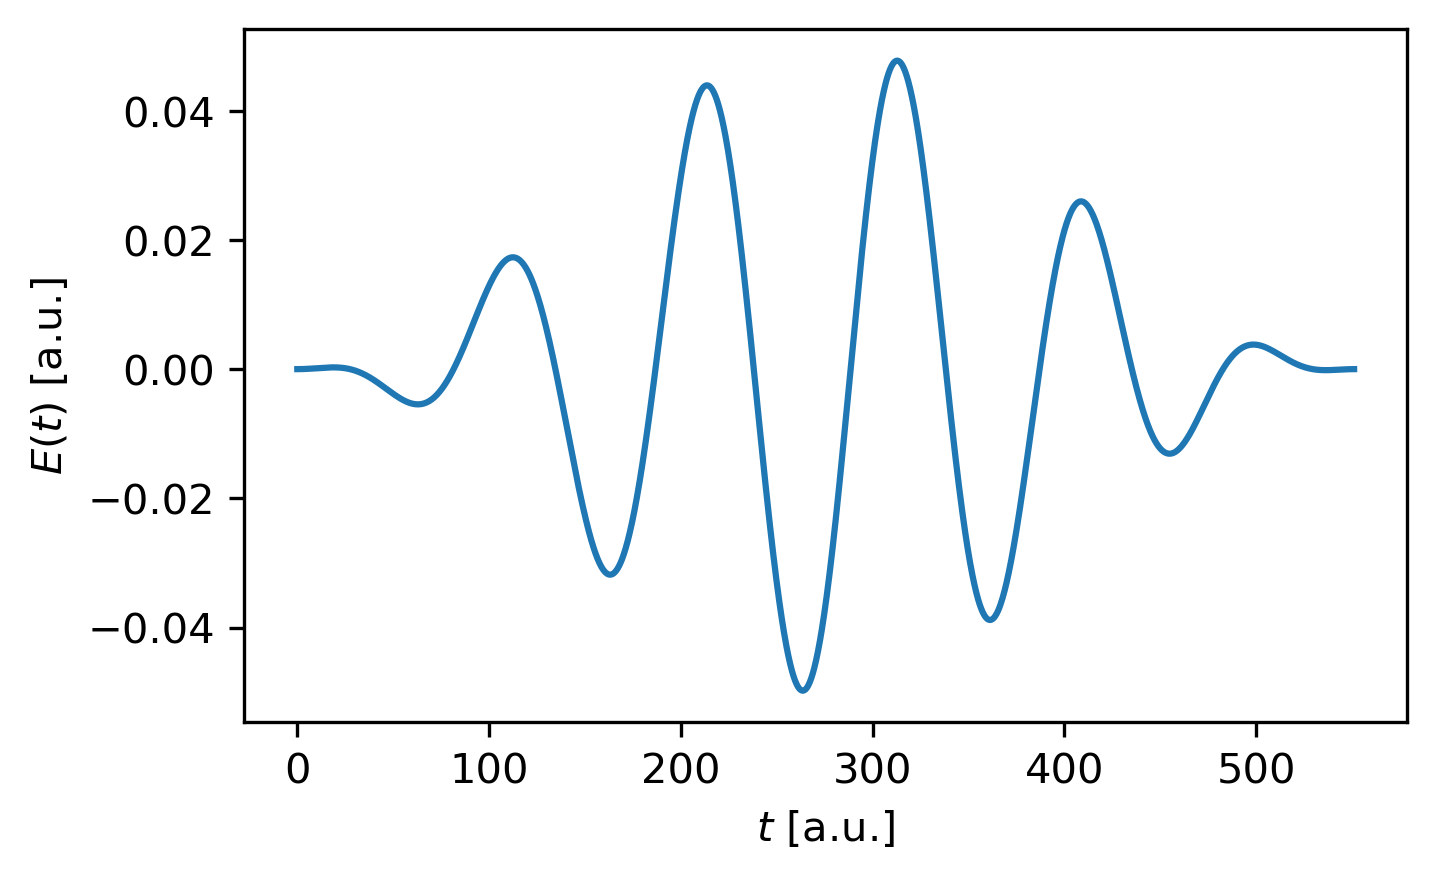

In [5]:
plot(inputs.get_tgrid(), inputs.get_Efield(), y_label=r"$E(t)$ [a.u.]", x_label=r"$t$ [a.u.]")

Compute the GS

In [6]:
DLL.init_GS(inputs)

and we can check the GS by plotting it

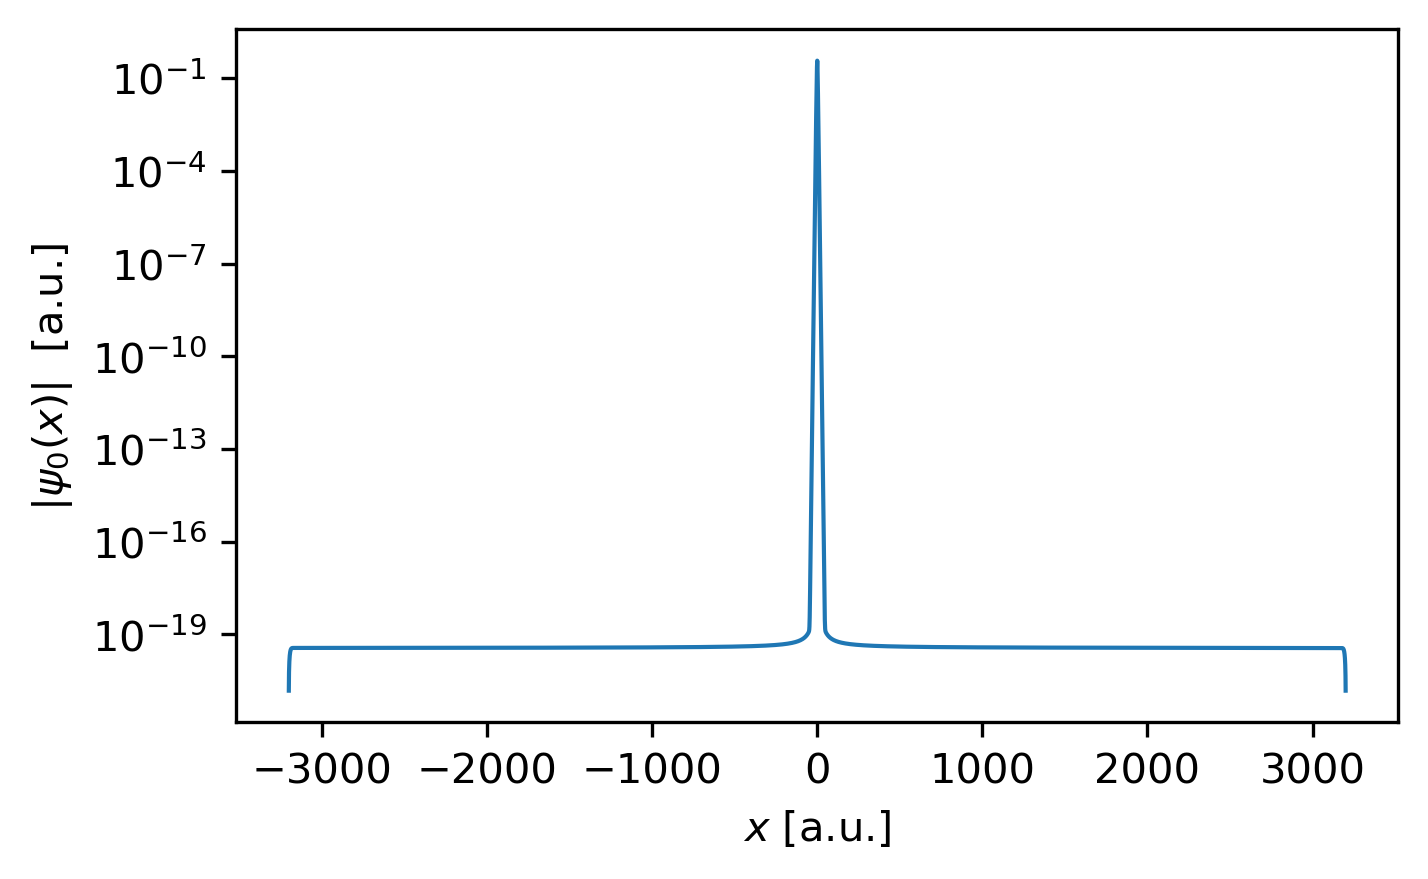

In [7]:
psi0 = inputs.get_GS()
x = inputs.get_xgrid()

plot(x, np.abs(psi0), plot_scale="log", x_label=r"$x$ [a.u.]", y_label = r"|$\psi_0(x)|$  [a.u.]", linewidth = 1.)

Propagate the wavefunction according to the field and store the results into the `outputs_def` structure. This part takes the most amount of computational time and it depends on the predetermined accuracy.

In [8]:
output = outputs_def()
### Call 1D TDSE from the inputs
DLL.call1DTDSE(inputs, output)

We may now plot the result of the computation. We can try plotting the averaged electron current derivative, $\partial_t \left<j(t)\right> = \left<\nabla V \right>(t) + E(t)$ along with the driving field during the propagation.

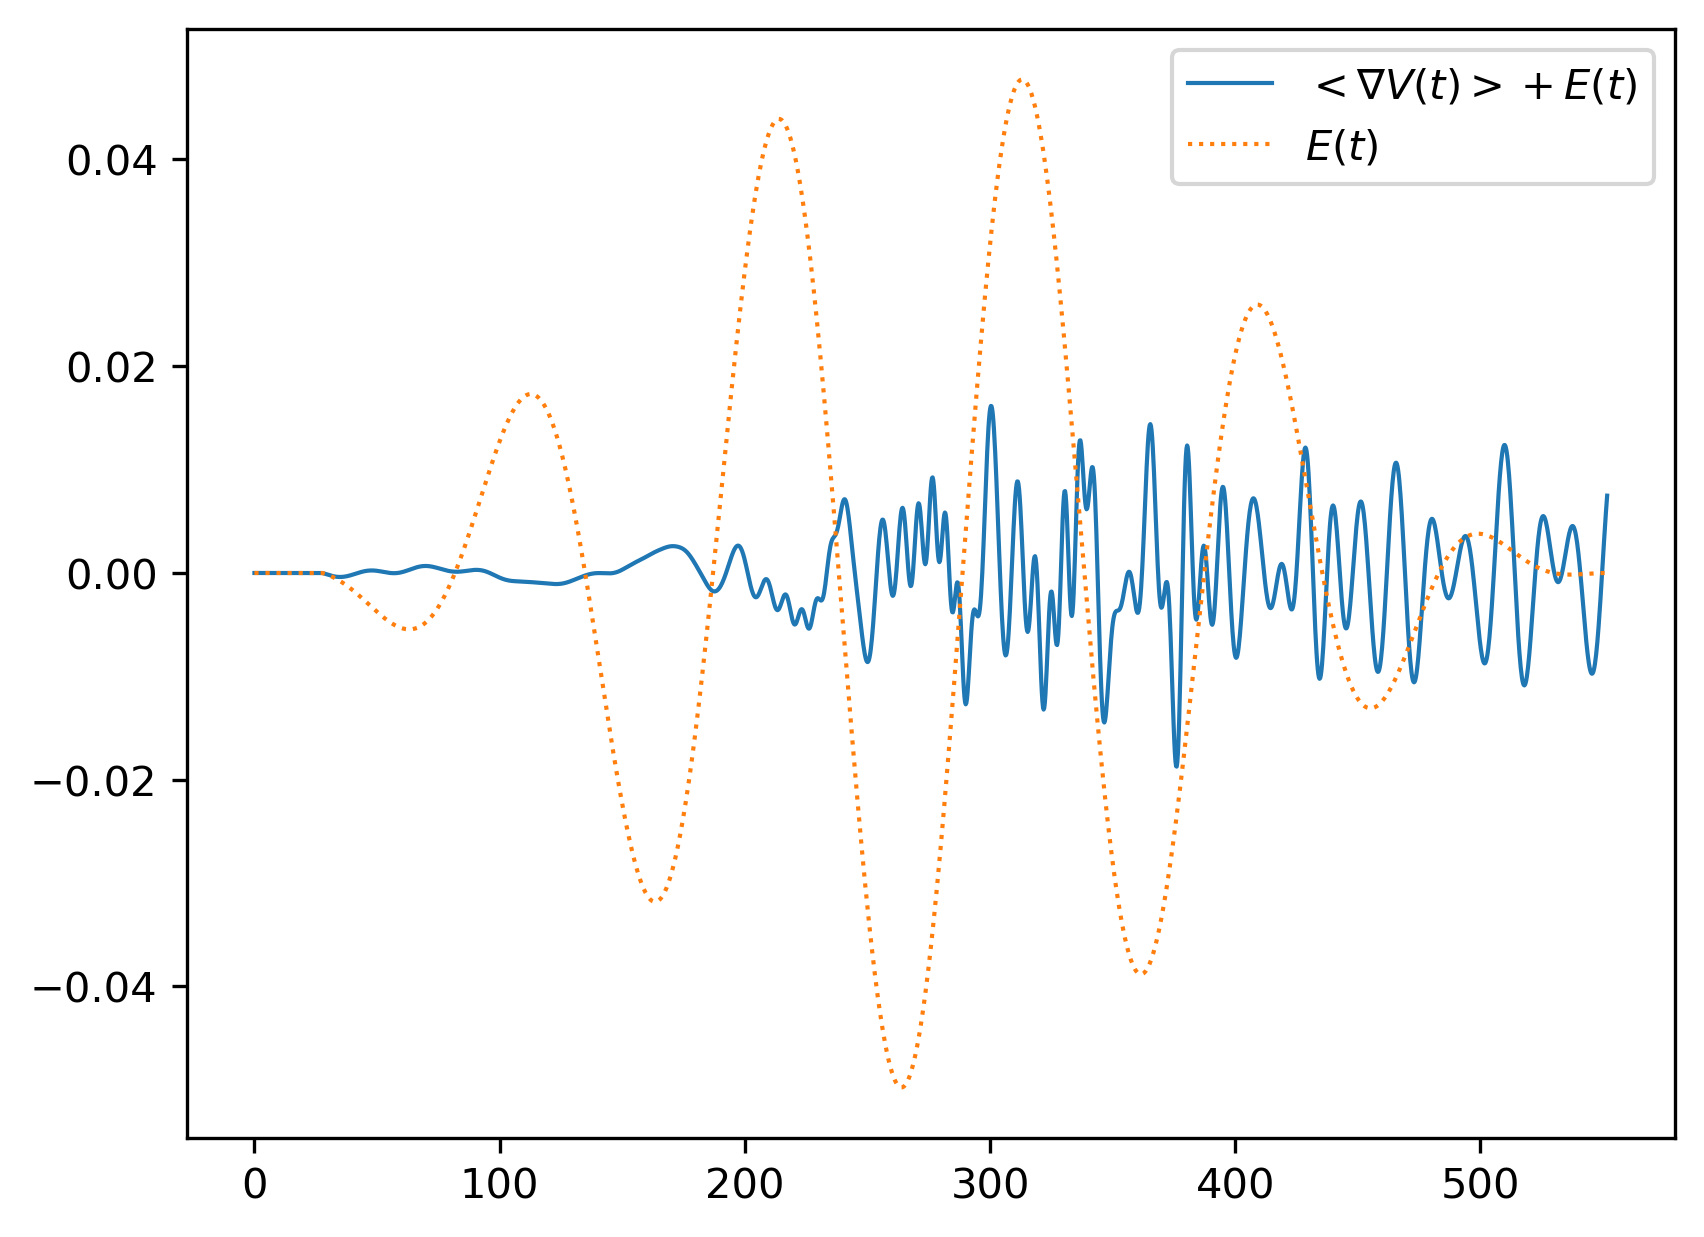

In [9]:
t = output.get_tgrid()
sourceterm = output.get_sourceterm()
E = output.get_Efield()
fig = plt.figure()
fig.dpi = 300
plt.plot(t, sourceterm, label = r"$<\nabla V(t)> + E(t)$", linewidth = 1)
plt.plot(t, E, label = r"$E(t)$", linewidth = 1, linestyle = ":")
plt.legend()
plt.show()

Compare the spectrum of the source term computed in CTDSE using FFTW with Numpy FFT. The FFT is normalized by a factor $dt/\sqrt{2 \pi}$.

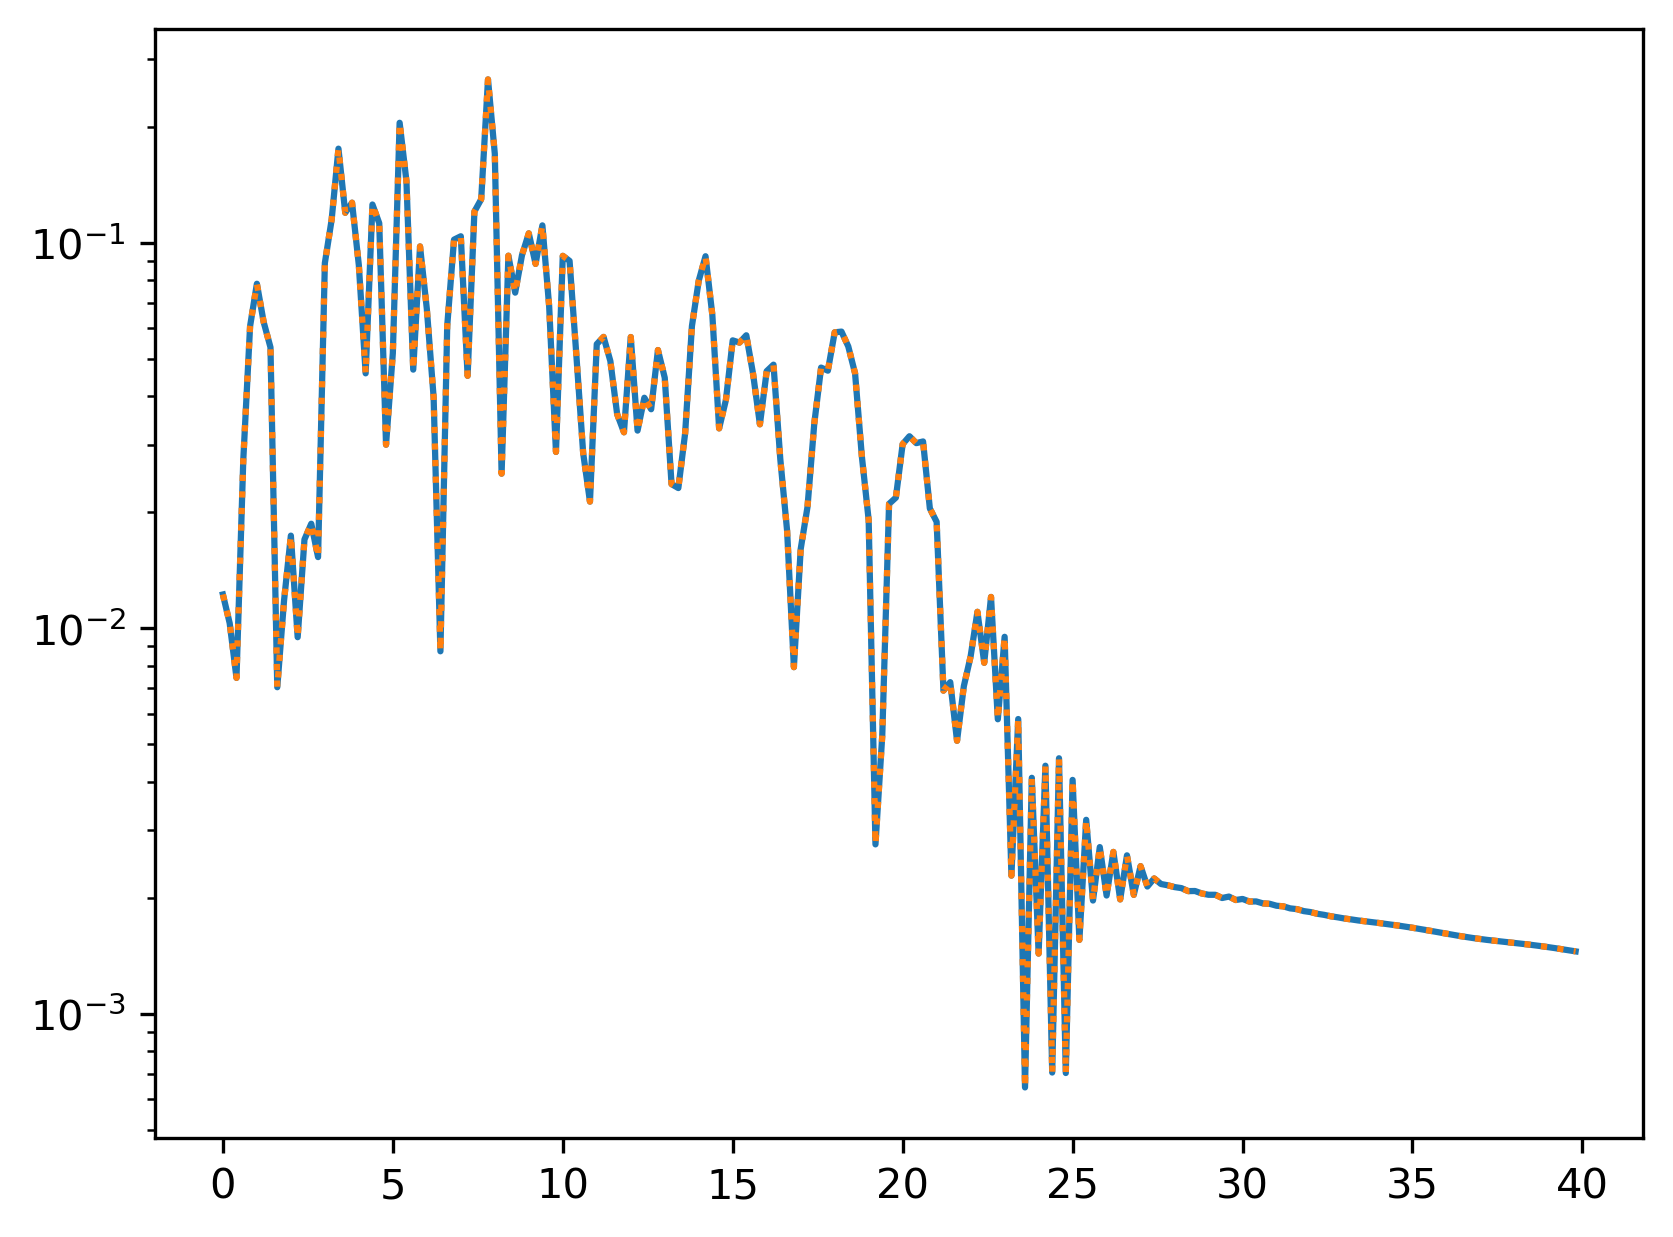

In [10]:
norm = (t[1]-t[0])/np.sqrt(2*np.pi)
omegas = output.get_omegagrid()[0:200]/omega_0

fig = plt.figure()
fig.dpi = 300
plt.semilogy(omegas, norm*np.abs(np.fft.fft(sourceterm))[0:200])
plt.semilogy(omegas, np.abs(output.get_Fsourceterm())[0:200], linestyle = ":")

plt.show()

### Free memory

The structures arrays should be freed after the termination of the Python kernel. We can free the memory using ```delete(DLL)``` methods of ```inputs_def``` and ```outputs_def``` structures.

We must provide the DLL class for the C wrapper.

In [13]:
inputs.delete(DLL)
output.delete(DLL)

## Plot wavefunction in $t$

In this example we show how to store the wavefunction and what can be done with it.

In [14]:
### Create instance of input structure
inputs = inputs_def()

### Initialize inputs, initialization functions are methods of inputs_def

### First we need to set the default inputs (can be modified with kwargs)
inputs.init_default_inputs()

Set writing and the timestep for wavefunction writing

In [15]:
### Set writing true
inputs.analy.writewft = c_int(1)
### Set wavefunction writing each 10 au in time
inputs.analy.tprint = c_double(10.)

In [16]:
### Fundamental frequency
omega_0 = 0.057
### Period
T = 2*np.pi/omega_0
### Pulse length
T_max = 5*T
### Number of time points
N_t = int(T_max/inputs.dt) + 1
### Temporal grid
t = np.linspace(0, T_max, N_t)
### Sine squared envelope
sin_2 = lambda t: np.sin(np.pi*t/T_max)**2
### Chirp
chirp = 1e-5*t**2
### Field magnitude
E_0 = 0.05
### Field
E = E_0*sin_2(t)*np.cos(omega_0*t + chirp)

assert(len(E) == len(t))
print("Size of the field and time grids: ", N_t)

Size of the field and time grids:  2205


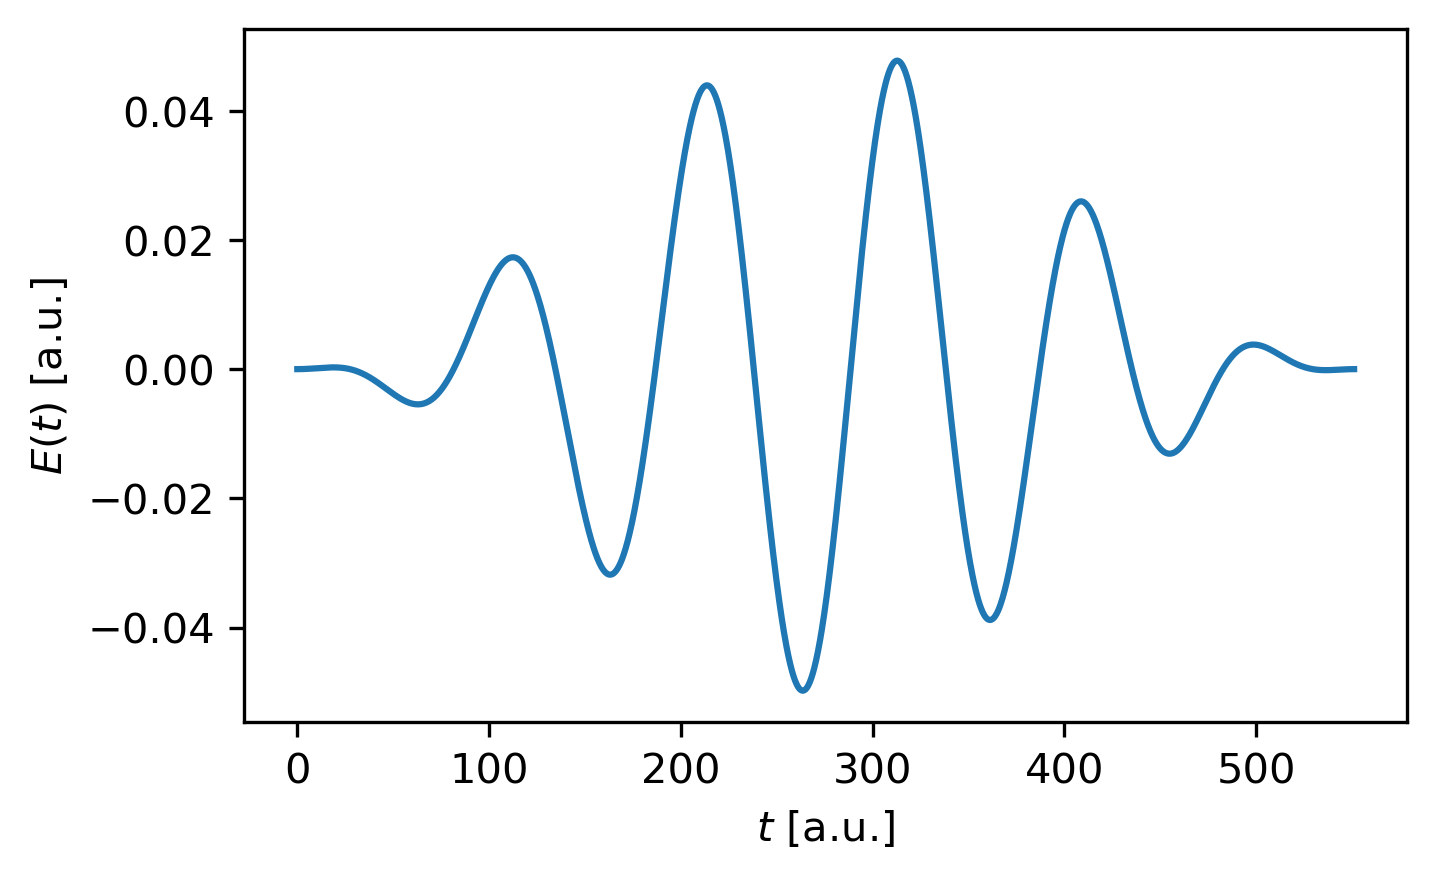

In [17]:
plot(t, E, y_label=r"$E(t)$ [a.u.]", x_label=r"$t$ [a.u.]")

In [18]:
inputs.init_time_and_field(DLL, E = E, t = t)
DLL.init_GS(inputs)

Call 1DTDSE and write the wavefunction

In [19]:
output = outputs_def()
### Call 1D TDSE from the inputs
DLL.call1DTDSE(inputs, output)

Load the wavefunction using the `get_wavefunction` method which returns a complex NDarray with the wavefunction and corresponding grids. The `inputs_def` object is a required argument.

In [20]:
### Load numpy array from the wavefunction, given the number of wavefunctions
### and given the size of the array for 1 wavefunction
tgrid, x, wavefunction = output.get_wavefunction(inputs)
print("Wavefunction size: ", wavefunction.shape)

Wavefunction size:  (56, 16001)


Select plotting range along $x$-axis:

In [21]:
x_range = (np.abs(x) < 1000.1)

Plot colormap of the wavefunction evolution (absolute value of $\psi$).

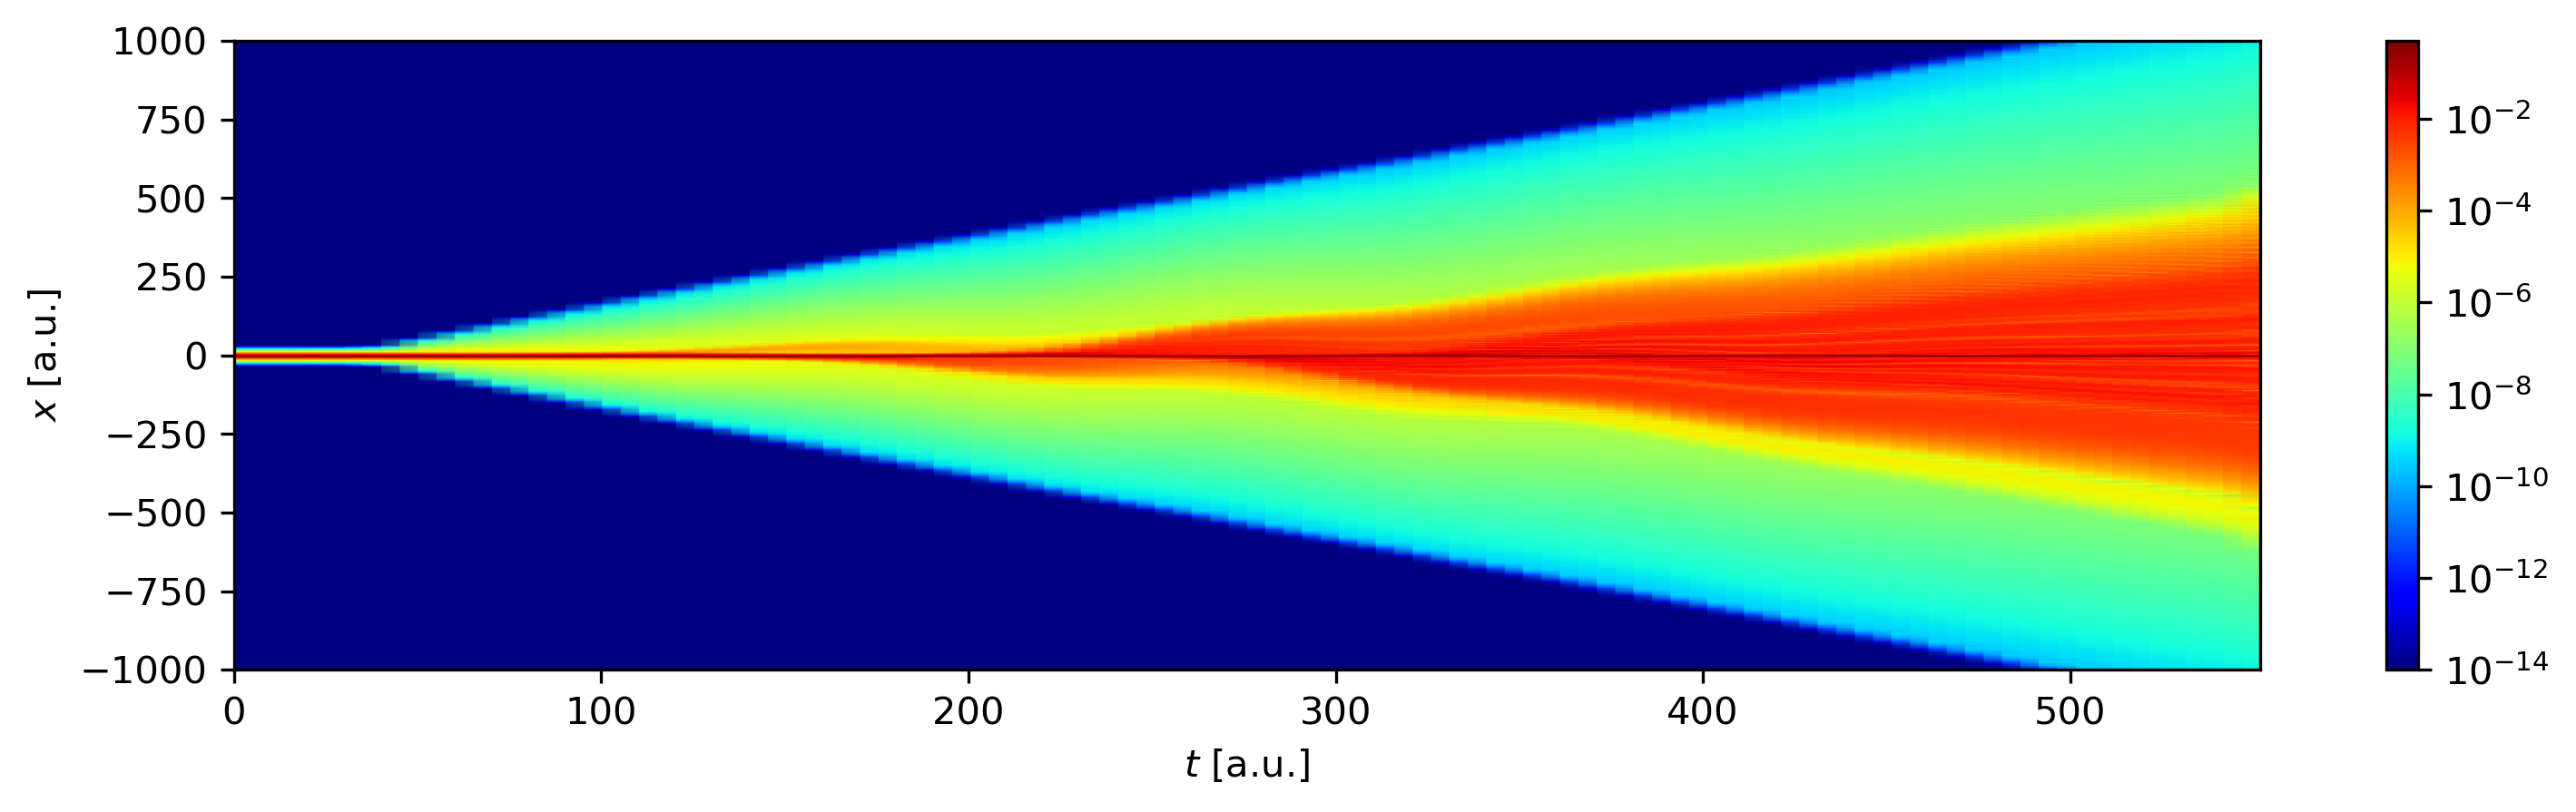

In [22]:
plot_colormap(x[x_range], tgrid, np.transpose(np.abs(wavefunction))[x_range], x_label=r"$t$ [a.u.]", y_label=r"$x$ [a.u.]", plot_scale="log", z_max=0.5)

Plot final wavefunction $\psi(t = T)$

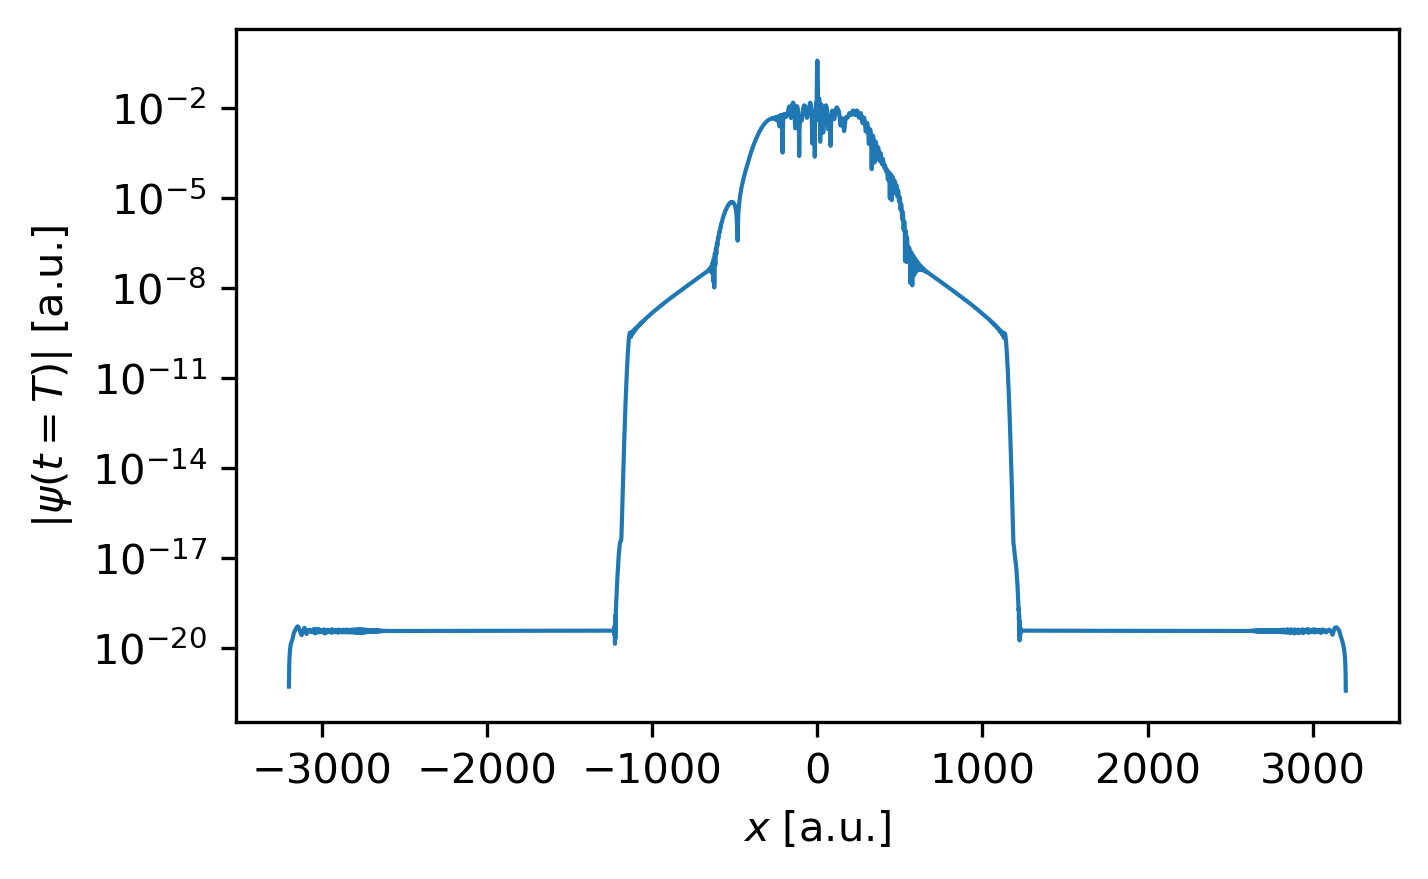

In [23]:
psi = wavefunction[-1]
plot(x, np.abs(psi), plot_scale="log", x_label=r"$x$ [a.u.]", y_label=r"$|\psi(t = T)|$ [a.u.]", linewidth = 1.)


### Computing photoelectron spectrum (PES) for the final $\psi$

Save the final wavefunction pointer

In [24]:
### Setting final wavefunction for the PES computation
#psi_final = output.psi[len(wavefunction)-1]
psi_final = wavefunction[-1].copy()

Compute PSE using the wrapper function, provided input structure and $\psi(t = T)$.

In [25]:
E, PSE = DLL.compute_PES(inputs, psi_final)

Plotting PES

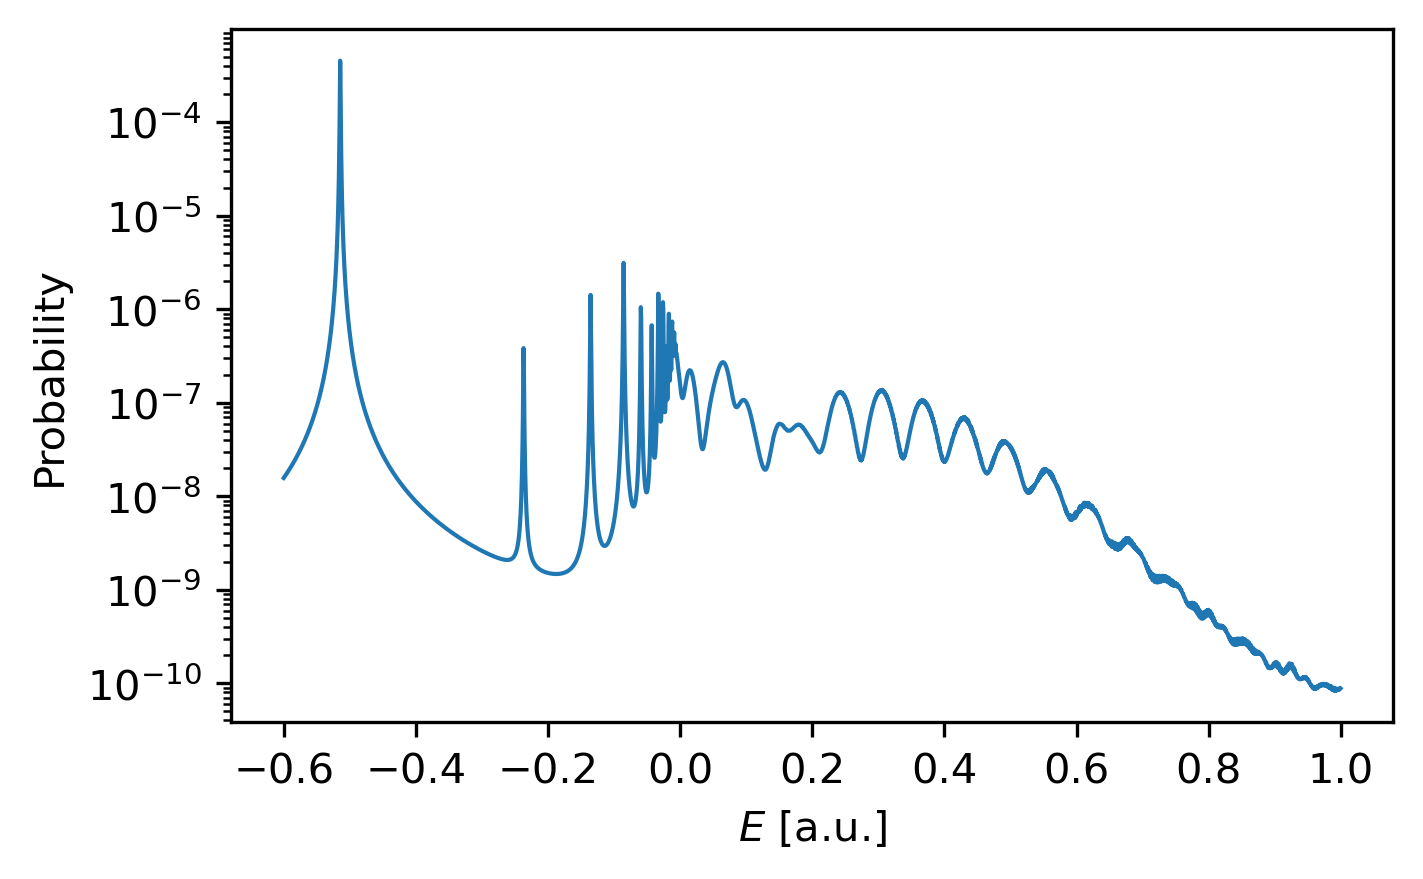

In [26]:
### Set range for plotting PES below 1 a.u. of energy
E_range = (E < 1.)

### Do the plot
plot((E[E_range]), PSE[E_range], y_label="Probability", x_label=r"$E$ [a.u.]", plot_scale="log", linewidth = 1.)

Free wavefunction in the outputs.

In [27]:
DLL.free_mtrx(output.psi, len(wavefunction))

### Print Gabor transform of $<\nabla V>$

In [28]:
grad_V = output.get_sourceterm()
dt = output.tgrid[1]-output.tgrid[0]
Nt = output.Nt
omega_0 = 0.057
omega_max = omega_0*35
T = output.tgrid[Nt-1]

In [29]:
t, omegas, gabor = DLL.gabor_transform(grad_V, dt, Nt, omega_max, 100., 400, 1000, a=8)

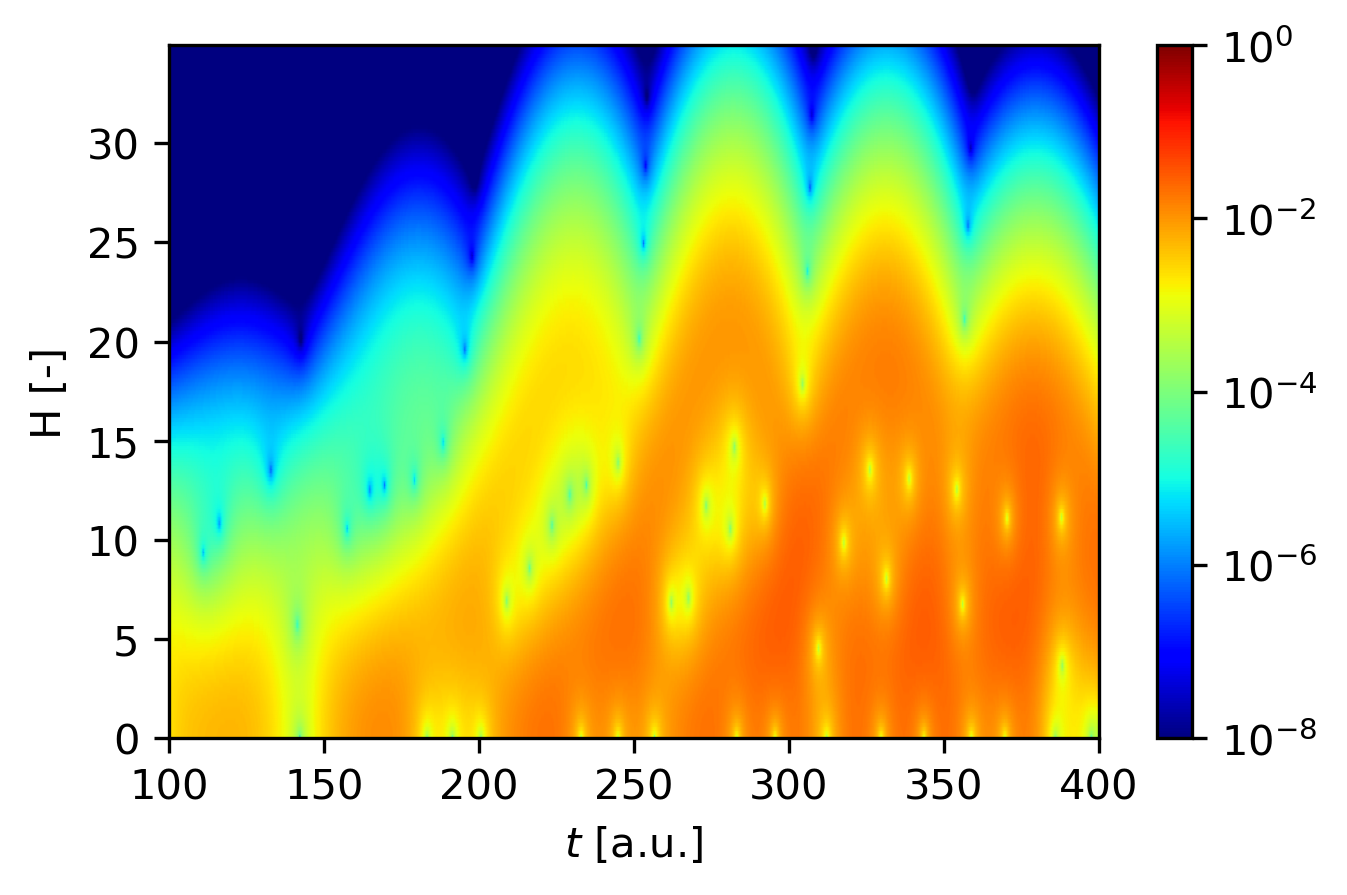

In [30]:
plot_colormap(omegas/omega_0, t, gabor, z_min=1e-8, figsize=(5, 3), x_label=r"$t$ [a.u.]", y_label=r"H [-]")

Free memory

In [31]:
inputs.delete(DLL)
output.delete(DLL)

## Save output and input to HDF5

In [2]:
### Create instance of input structure
inputs = inputs_def()

### First we need to set the default inputs (can be modified with kwargs)
inputs.init_default_inputs()

In [3]:
### Set writing true
inputs.analy.writewft = c_int(1)
### Set wavefunction writing each 10 au in time
inputs.analy.tprint = c_double(10.)

In [4]:
### Fundamental frequency
omega_0 = 0.057
### Period
T = 2*np.pi/omega_0
### Pulse length
T_max = 5*T
### Number of time points
N_t = int(T_max/inputs.dt) + 1
### Temporal grid
t = np.linspace(0, T_max, N_t)
### Sine squared envelope
sin_2 = lambda t: np.sin(np.pi*t/T_max)**2
### Chirp
chirp = 1e-5*t**2
### Field magnitude
E_0 = 0.05
### Field
E = E_0*sin_2(t)*np.cos(omega_0*t + chirp)

assert(len(E) == len(t))
print("Size of the field and time grids: ", N_t)

Size of the field and time grids:  2205


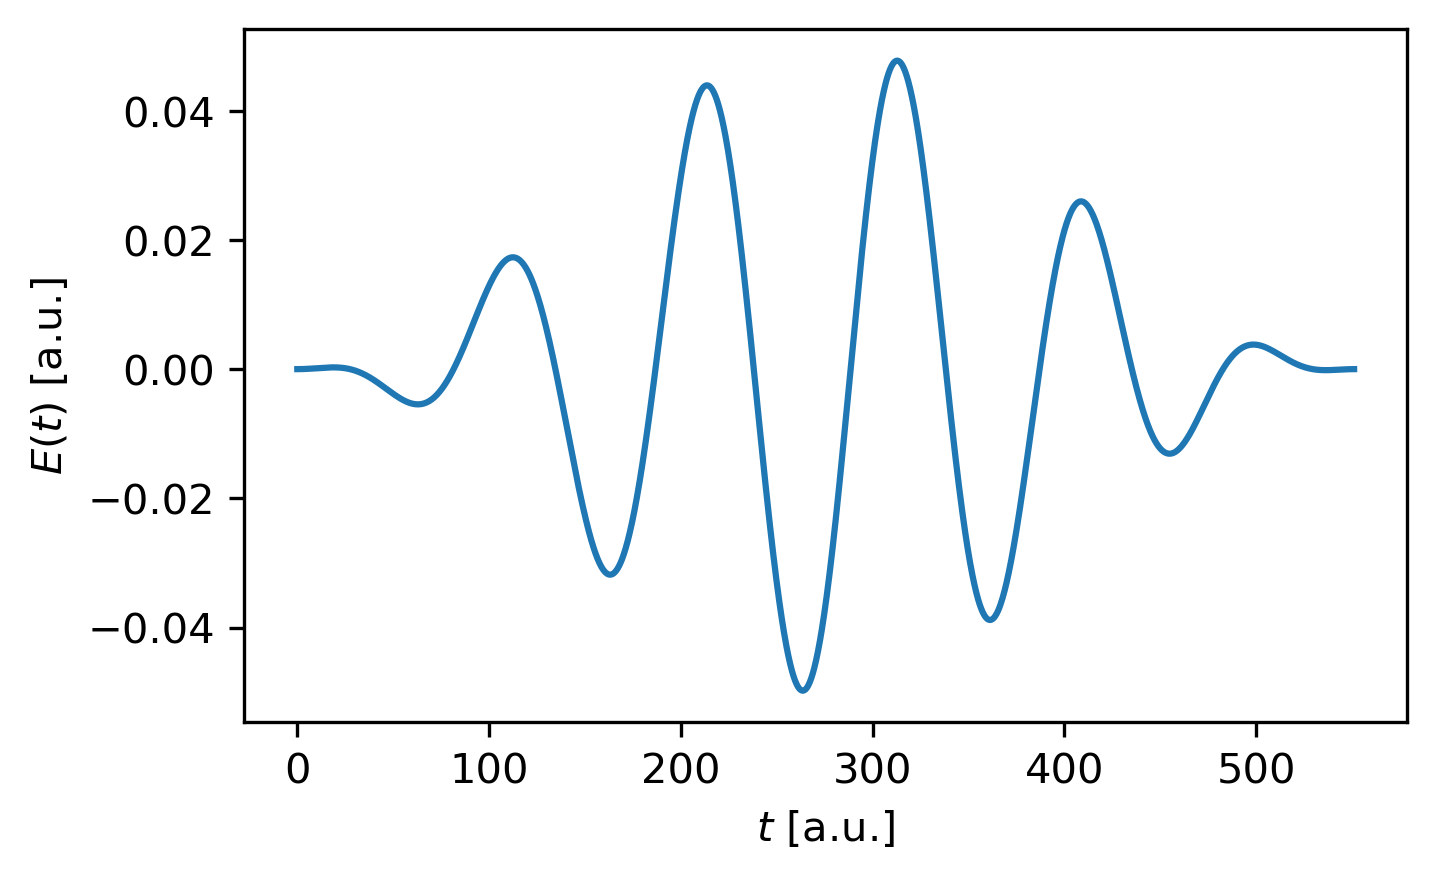

In [5]:
plot(t, E, y_label=r"$E(t)$ [a.u.]", x_label=r"$t$ [a.u.]")

In [6]:
inputs.init_time_and_field(DLL, E = E, t = t)
DLL.init_GS(inputs)

Save the inputs

In [7]:
inputs.save_to_hdf5("test.h5")

Compute CTDSE

In [8]:
output = outputs_def()
### Call 1D TDSE from the inputs
DLL.call1DTDSE(inputs, output)

Save the outputs. If kwarg ```inputs = inputs```, then it writes the wavefunction into the HDF5 file, if available by ```write_wft = 1```. The wavefunction is saved within the HDF5 file as 2 datasets: real and imaginary part of the wavefunction for the predefined discretization in time. 

In [9]:
output.save_to_hdf5("test.h5", inputs=inputs)

Delete wavefunction

In [10]:
wavefunction = output.get_wavefunction(inputs, grids=False)
DLL.free_mtrx(output.psi, len(wavefunction))

Delete memory

In [11]:
inputs.delete(DLL)
output.delete(DLL)

We can load back the input from the HDF5 file for new computations using the ```load_from_hdf5()``` method.

In [12]:
inputs = inputs_def()
inputs.load_from_hdf5("test.h5")

Check if loaded correctly

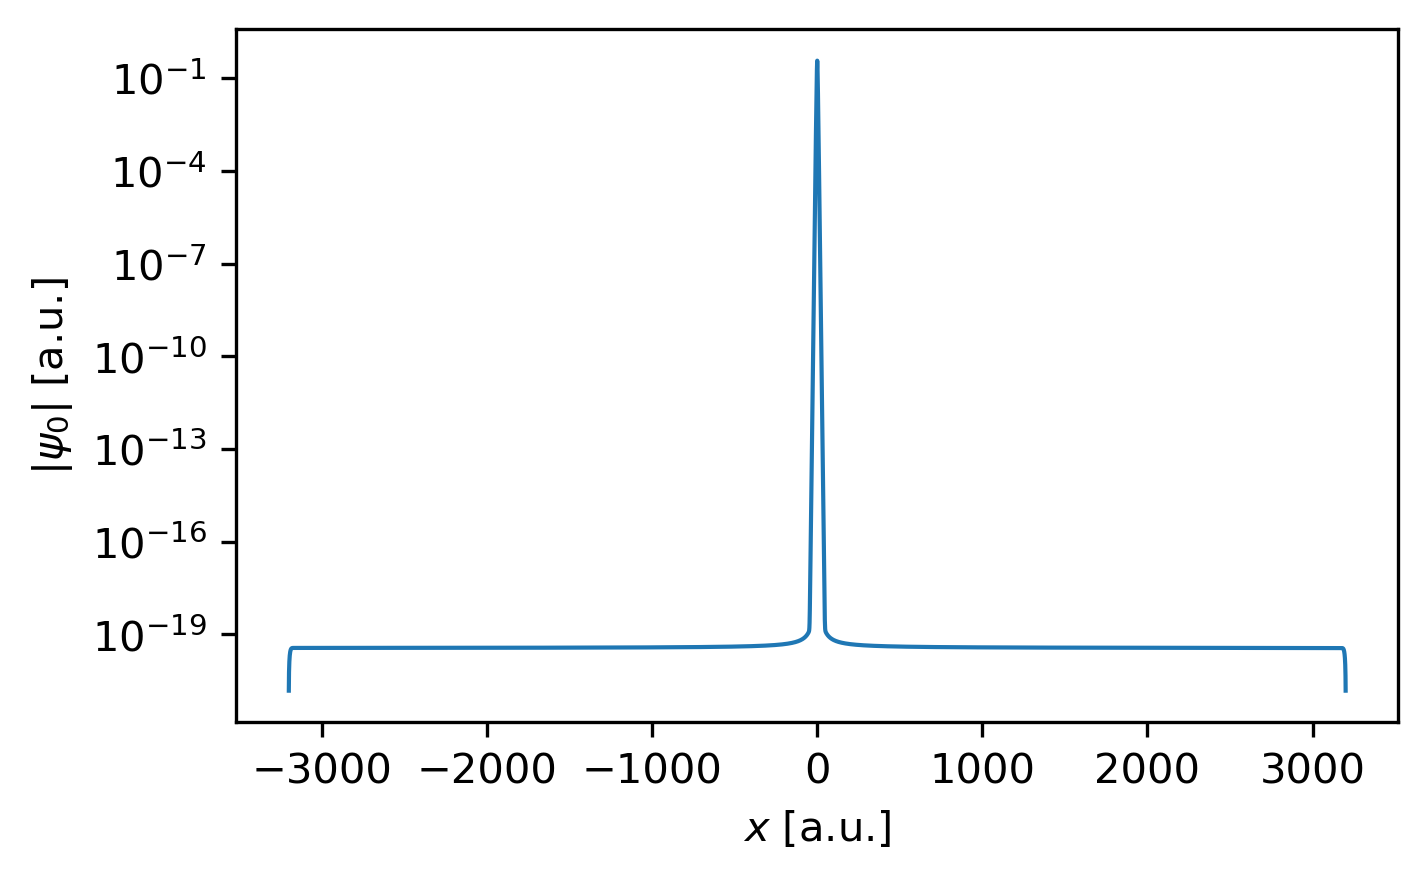

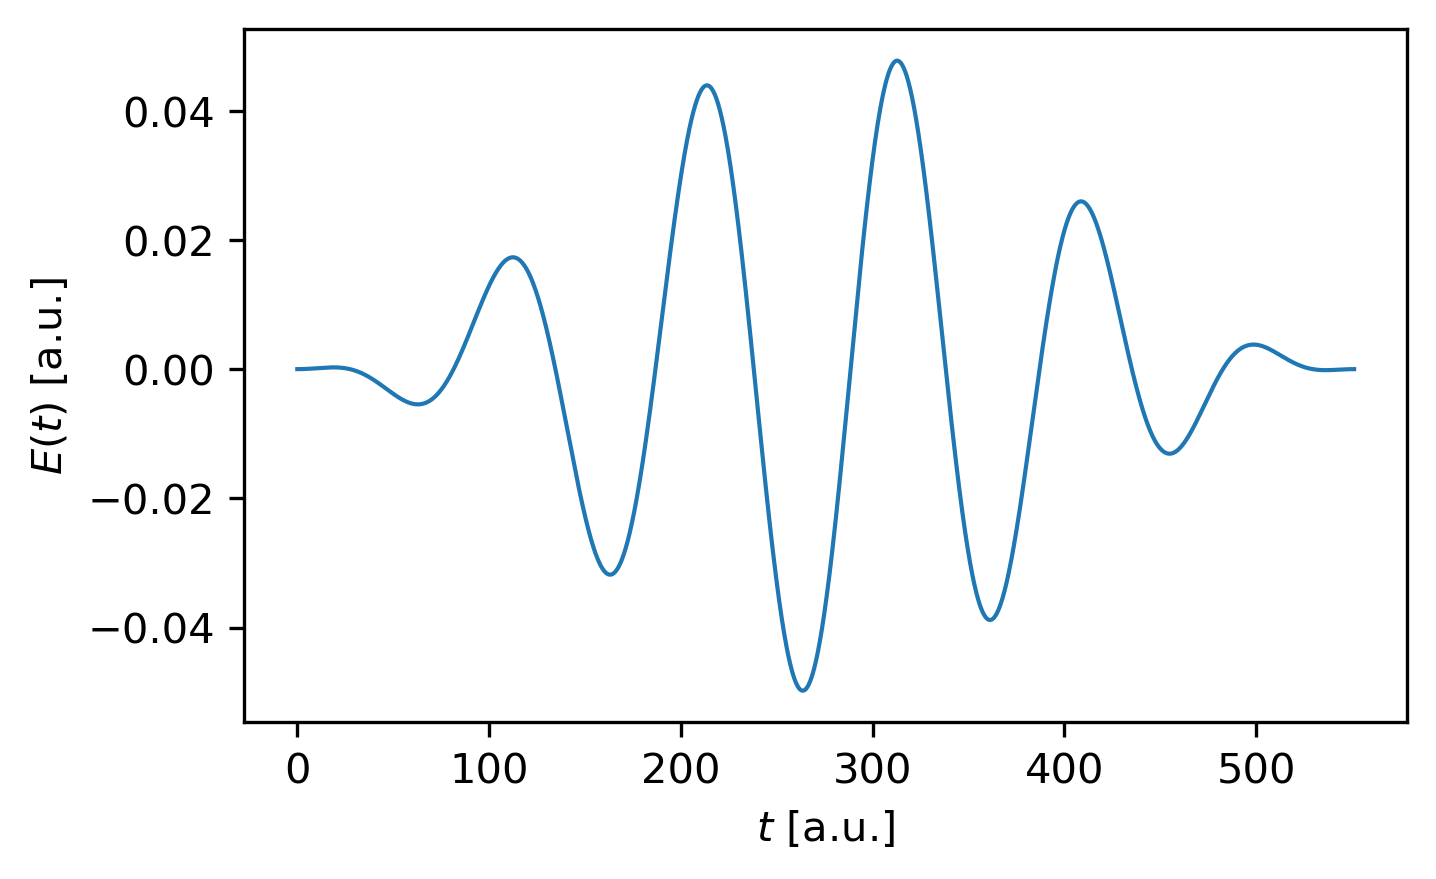

In [13]:
plot(inputs.get_xgrid(), np.abs(inputs.get_GS()), plot_scale = "log", linewidth = 1., x_label=r"$x$ [a.u.]", y_label=r"$|\psi_0|$ [a.u.]")
plot(inputs.get_tgrid(), inputs.get_Efield(), linewidth = 1., x_label=r"$t$ [a.u.]", y_label=r"$E(t)$ [a.u.]")

Propagate the loaded inputs

In [14]:
output = outputs_def()
### Call 1D TDSE from the inputs
DLL.call1DTDSE(inputs, output)

Plot data

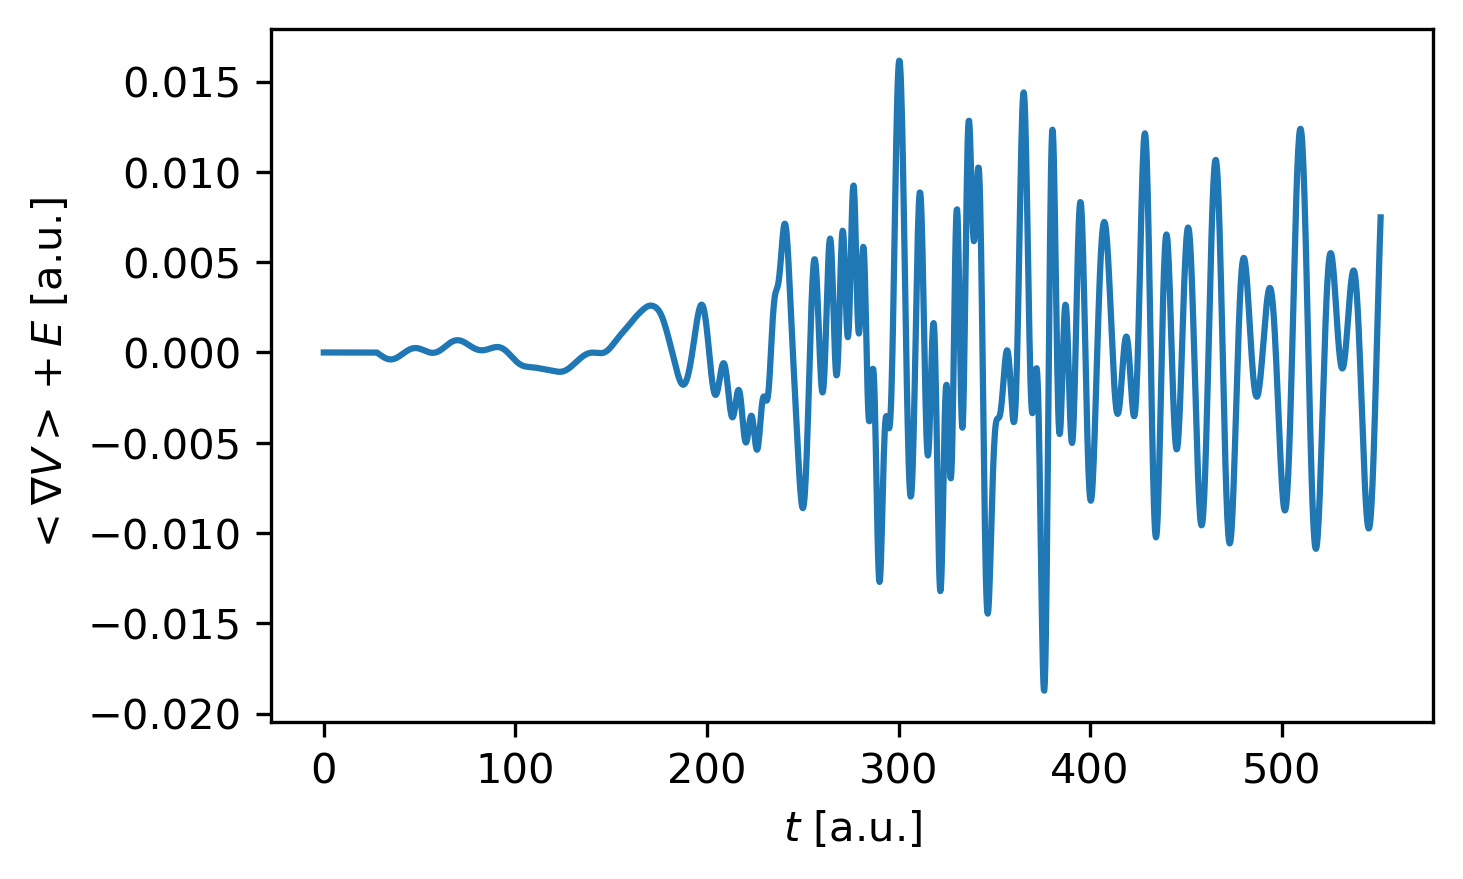

In [15]:
plot(output.get_tgrid(), output.get_sourceterm(), x_label=r"$t$ [a.u.]", y_label=r"$<\nabla V> + E$ [a.u.]")

Delete data

In [16]:
DLL.free_mtrx(output.psi, len(wavefunction))
inputs.delete(DLL)
output.delete(DLL)

## Time-dependent probability density resolved in energy using ROM

Recomputing the case from the article ["Ionization dynamics and gauge invariance" by Vábek, J., Bachau, H and Catoire, F.](https://doi.org/10.1103/PhysRevA.106.053115).

In [17]:
### Create instance of input structure
inputs = inputs_def()

inputs.init_default_inputs(trg_a=1.1893, dt = 0.25, CV=1e-15)

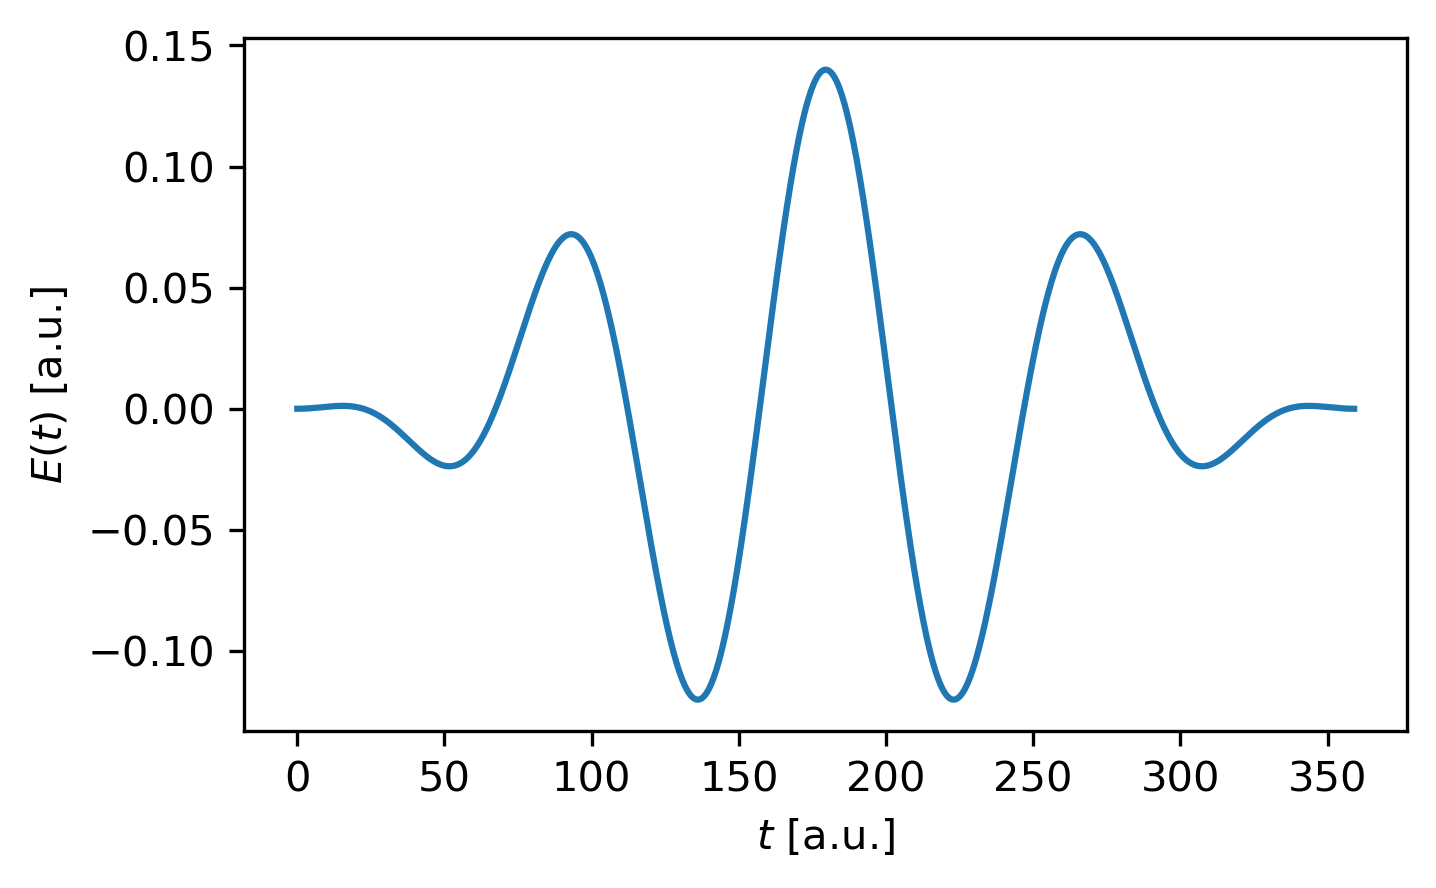

In [18]:
### Field amplitude
E_0 = 0.14
### Fundamental frequency
omega_0 = 0.07
### Number of cycles
Nc = 4
### Period
T = 2*np.pi/omega_0
### Pulse length
T_max = Nc*T
### Number of time points
N_t = int(T_max/inputs.dt) + 1
### Temporal grid
t = np.linspace(0, T_max, N_t)
### Sine squared envelope
sin_2 = lambda t: np.sin(np.pi*t/T_max)**2

### Field
Efield = E_0*sin_2(t)*np.cos(omega_0*t)

plot(t, Efield, y_label=r"$E(t)$ [a.u.]", x_label=r"$t$ [a.u.]")

In [19]:
inputs.init_time_and_field(DLL, E = Efield, t = t)
DLL.init_GS(inputs)

Compute first 16 ground states of Argon

In [20]:
Energy_guess = [-0.5789, -0.2537, -0.1425, -0.0890, -0.0613, -0.0440, -0.0335, -0.0265, -0.0213, -0.0175, -0.0145, -0.0105, -0.0080, -0.0065, -0.0050, -0.0035]
inputs_array = []
GS = []
for i, E in enumerate(Energy_guess):
    inputs_array.append(inputs_def())
    ### Remark that CV = 1e-15, else the resolvent does not converge for higher bound states
    inputs_array[i].init_default_inputs(Eguess=E, num_r=inputs.num_r, trg_a=1.1893, dt = 0.25, CV = 1e-15)
    DLL.init_GS(inputs_array[i]) 
    print("E_GS = {}".format(inputs_array[i].Einit))
    GS.append(inputs_array[i].get_GS())

GS = np.array(GS)

### Delete the inputs array
for i, E, in enumerate(inputs_array):
    inputs_array[i].delete(DLL)

E_GS = -0.5791557676114921
E_GS = -0.25374645982949645
E_GS = -0.1426480826645878
E_GS = -0.08881526059436329
E_GS = -0.06123214193246611
E_GS = -0.044195897055493684
E_GS = -0.033692585133068574
E_GS = -0.026305719444008568
E_GS = -0.021257668321381634
E_GS = -0.017417774348982572
E_GS = -0.014617676984749271
E_GS = -0.01066294497532975
E_GS = -0.008119678120588444
E_GS = -0.006388383827560039
E_GS = -0.005156983902165675
E_GS = -0.003562909769468573


Print bound states shape

In [21]:
GS.shape

(16, 16001)

Set writing wavefunction every $dt = 1.$

In [22]:
### Set writing true
inputs.analy.writewft = c_int(1)
### Set wavefunction writing each 10 au in time
inputs.analy.tprint = c_double(1.)

Compute the output

In [23]:
output = outputs_def()
### Call 1D TDSE from the inputs
DLL.call1DTDSE(inputs, output)

Save inputs and outputs to HDF5, keep the wavefunction

In [24]:
inputs.save_to_hdf5("ionization.h5")
output.save_to_hdf5("ionization.h5", inputs=inputs)
t_psi, x_grid, wavefunction = output.get_wavefunction(inputs, grids=True)

Now the bound states are removed from $\psi$ in each timestep and the photoelectron spectrum is computed using the resolvent operator method.

In [27]:
### Final photoelectron spectrum array
PES_array = []

wfs = wavefunction[0:-1:1]
### Iterate over all stored wavefunctions
for i, psi in enumerate(wfs):
    print("Processing {} out of {}.".format(i+1, len(wfs)))
    for psi_b in GS:
        ### Remove the bound states using projection (note: np.vdot(a, b) == np.dot(np.conj(a), b) )
        psi -= np.vdot(psi, psi_b)*psi_b

    ### Convert psi into a C-comprehensible array - flatten first, alternate real 
    # and imaginary parts, then return pointer to array
    psi = np.array([psi.real, psi.imag]).transpose().flatten()
    psi_ptr = ctypes_arr_ptr(c_double, len(psi), psi)

    ### Compute photoelectron spectrum for range (-0.6) to (7) a.u. of energy
    Energy = np.linspace(-0.6, 7, 2000)
    Estep = Energy[1]-Energy[0]
    E_grid, PES = DLL.compute_PES(inputs, psi_ptr, num_E=len(Energy), Estep=Estep)

    ### Store the result
    PES_array.append(PES)


Processing 0 out of 96.
Processing 1 out of 96.
Processing 2 out of 96.
Processing 3 out of 96.
Processing 4 out of 96.
Processing 5 out of 96.
Processing 6 out of 96.
Processing 7 out of 96.
Processing 8 out of 96.
Processing 9 out of 96.
Processing 10 out of 96.
Processing 11 out of 96.
Processing 12 out of 96.
Processing 13 out of 96.
Processing 14 out of 96.
Processing 15 out of 96.
Processing 16 out of 96.
Processing 17 out of 96.
Processing 18 out of 96.
Processing 19 out of 96.
Processing 20 out of 96.
Processing 21 out of 96.
Processing 22 out of 96.
Processing 23 out of 96.
Processing 24 out of 96.
Processing 25 out of 96.
Processing 26 out of 96.
Processing 27 out of 96.
Processing 28 out of 96.
Processing 29 out of 96.
Processing 30 out of 96.
Processing 31 out of 96.
Processing 32 out of 96.
Processing 33 out of 96.
Processing 34 out of 96.
Processing 35 out of 96.
Processing 36 out of 96.
Processing 37 out of 96.
Processing 38 out of 96.
Processing 39 out of 96.
Processing

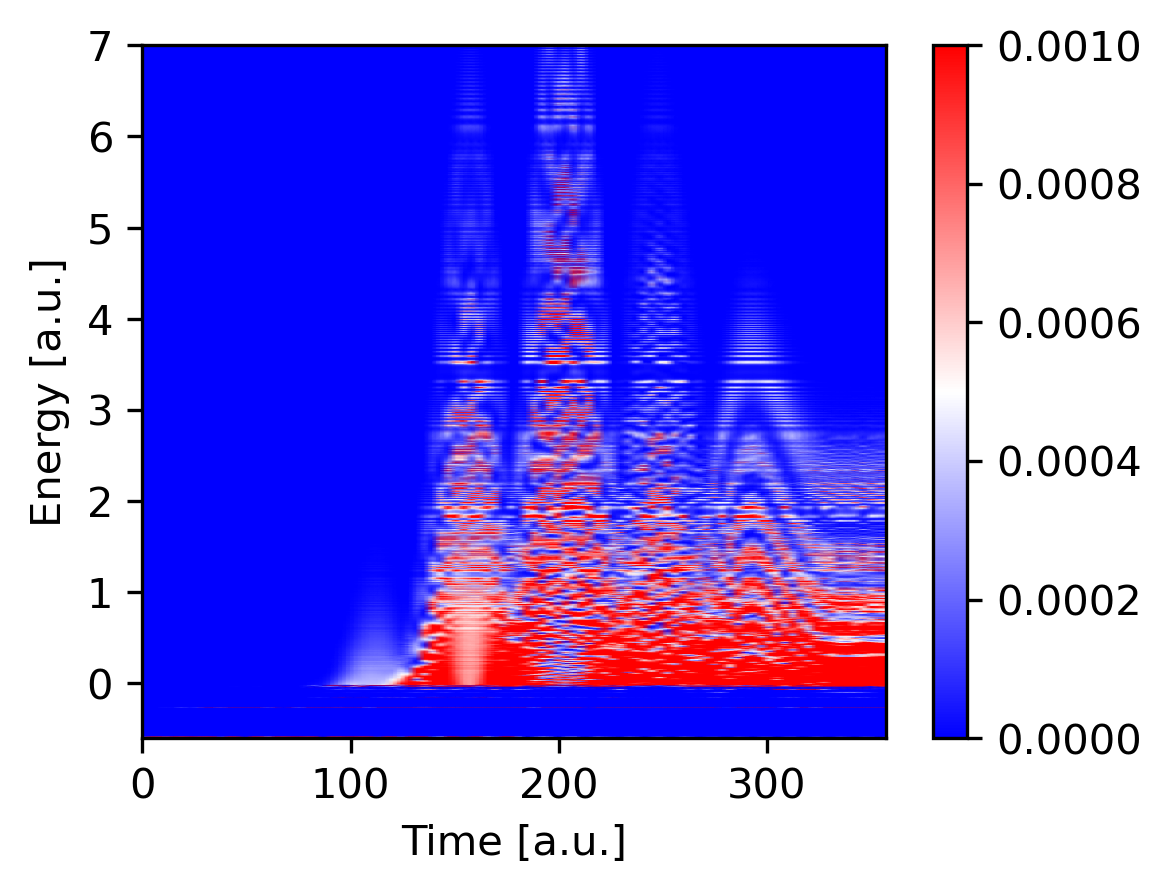

In [37]:
plot_colormap(Energy, t_psi[0:-1:1], np.array(PES_array).transpose(), plot_scale="linear", 
              z_max = 1e-3, figsize=(4, 3), y_label="Energy [a.u.]", x_label="Time [a.u.]", cmap="bwr")

Parallel evaluation of PES using `multiprocess` package.

In [25]:
from multiprocess import Pool

In [26]:
def compute_PES_parallel(psi, GS, N_pts, E_min, E_max, jobID):
    for psi_b in GS:
        ### Remove the bound states using projection (note: np.vdot(a, b) == np.dot(np.conj(a), b) )
        psi -= np.vdot(psi, psi_b)*psi_b

    ### Convert psi into a C-comprehensible array - flatten first, alternate real 
    # and imaginary parts, then return pointer to array
    #psi = np.array([psi.real, psi.imag]).transpose().flatten()
    #psi_ptr = ctypes_arr_ptr(c_double, len(psi), psi)

    ### Compute photoelectron spectrum for range (-0.6) to (7) a.u. of energy
    Energy = np.linspace(E_min, E_max, N_pts)
    Estep = Energy[1]-Energy[0]
    #E_grid, PES = DLL.compute_PES(inputs, psi_ptr, num_E=len(Energy), Estep=Estep)
    E_grid, PES = DLL.compute_PES(inputs, psi, num_E=len(Energy), Estep=Estep)

    print("Job {} done.".format(jobID))
    ### Store the result
    return E_grid, PES

In [27]:
### 6 parallel processes
p = Pool(6)

N_pts = 8000
E_min = -0.6
E_max = 7.
map_ = [(wf, GS, N_pts, E_min, E_max, i+1) for i, wf in enumerate(wavefunction)]
result = p.starmap_async(compute_PES_parallel, map_)

PES = result.get()

Job 1 done.
Job 61 done.
Job 21 done.
Job 81 done.
Job 101 done.
Job 41 done.
Job 2 done.
Job 22 done.
Job 62 done.
Job 82 done.
Job 102 done.
Job 42 done.
Job 3 done.
Job 83 done.
Job 23 done.
Job 63 done.
Job 43 done.Job 103 done.

Job 84 done.
Job 44 done.
Job 64 done.
Job 24 done.
Job 4 done.
Job 104 done.
Job 85 done.
Job 25 done.
Job 65 done.
Job 5 done.
Job 45 done.
Job 105 done.
Job 86 done.
Job 26 done.
Job 66 done.
Job 6 done.
Job 106 done.
Job 46 done.
Job 87 done.
Job 7 done.
Job 67 done.Job 27 done.

Job 107 done.
Job 47 done.
Job 88 done.
Job 8 done.
Job 28 done.
Job 68 done.
Job 108 done.
Job 48 done.
Job 89 done.
Job 9 done.
Job 29 done.
Job 69 done.
Job 109 done.
Job 49 done.
Job 10 done.
Job 90 done.
Job 30 done.
Job 70 done.
Job 110 done.
Job 50 done.
Job 91 done.
Job 31 done.
Job 71 done.
Job 11 done.
Job 111 done.
Job 51 done.
Job 92 done.
Job 32 done.
Job 112 done.
Job 12 done.
Job 72 done.
Job 52 done.
Job 93 done.
Job 33 done.
Job 113 done.
Job 13 done.
Job 73 d

In [28]:
PES_array = [PES[i][1] for i in range(len(PES))]

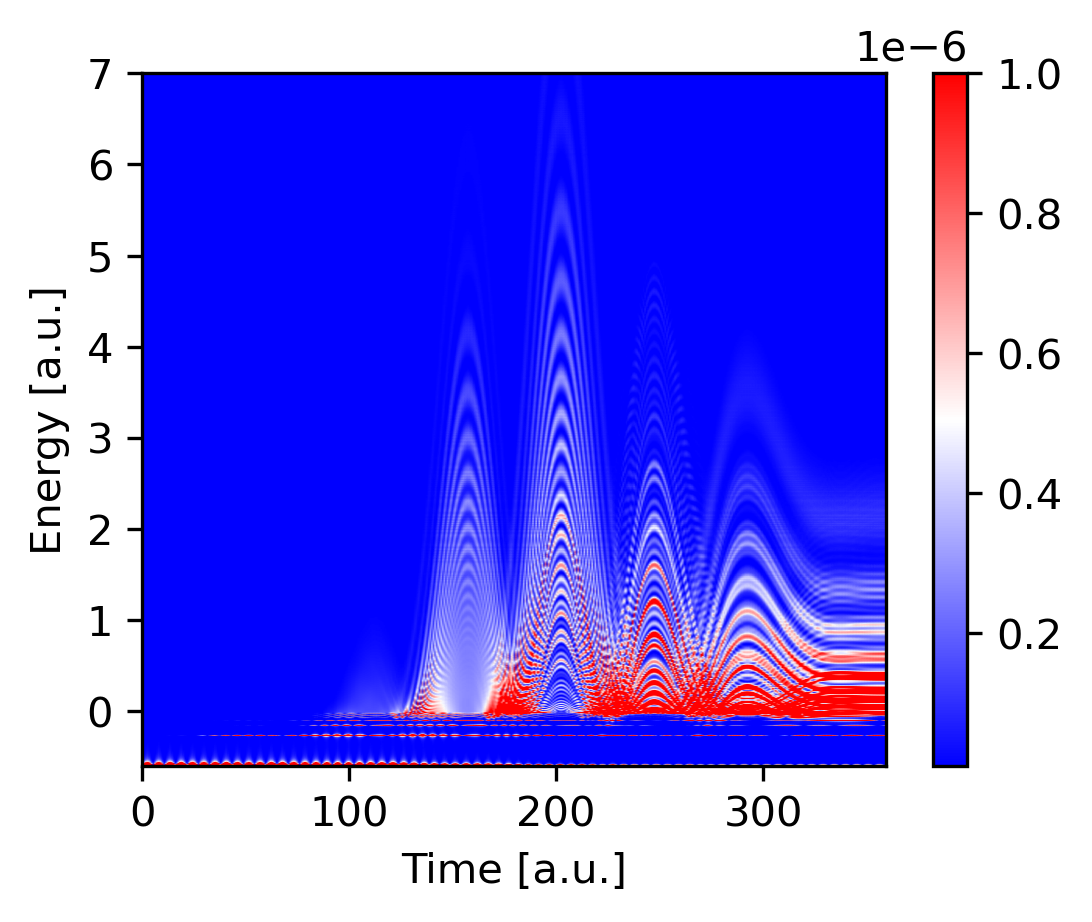

In [32]:
plot_colormap(np.linspace(E_min, E_max, N_pts), t_psi, np.array(PES_array).transpose(), plot_scale="linear", 
              z_max = 1e-6, figsize=(4, 3), y_label="Energy [a.u.]", x_label="Time [a.u.]", cmap="bwr", z_min=1e-8)

Free memory

In [12]:
### Free memory
DLL.free_mtrx(output.psi, len(wavefunction))

In [13]:
inputs.delete(DLL)
output.delete(DLL)

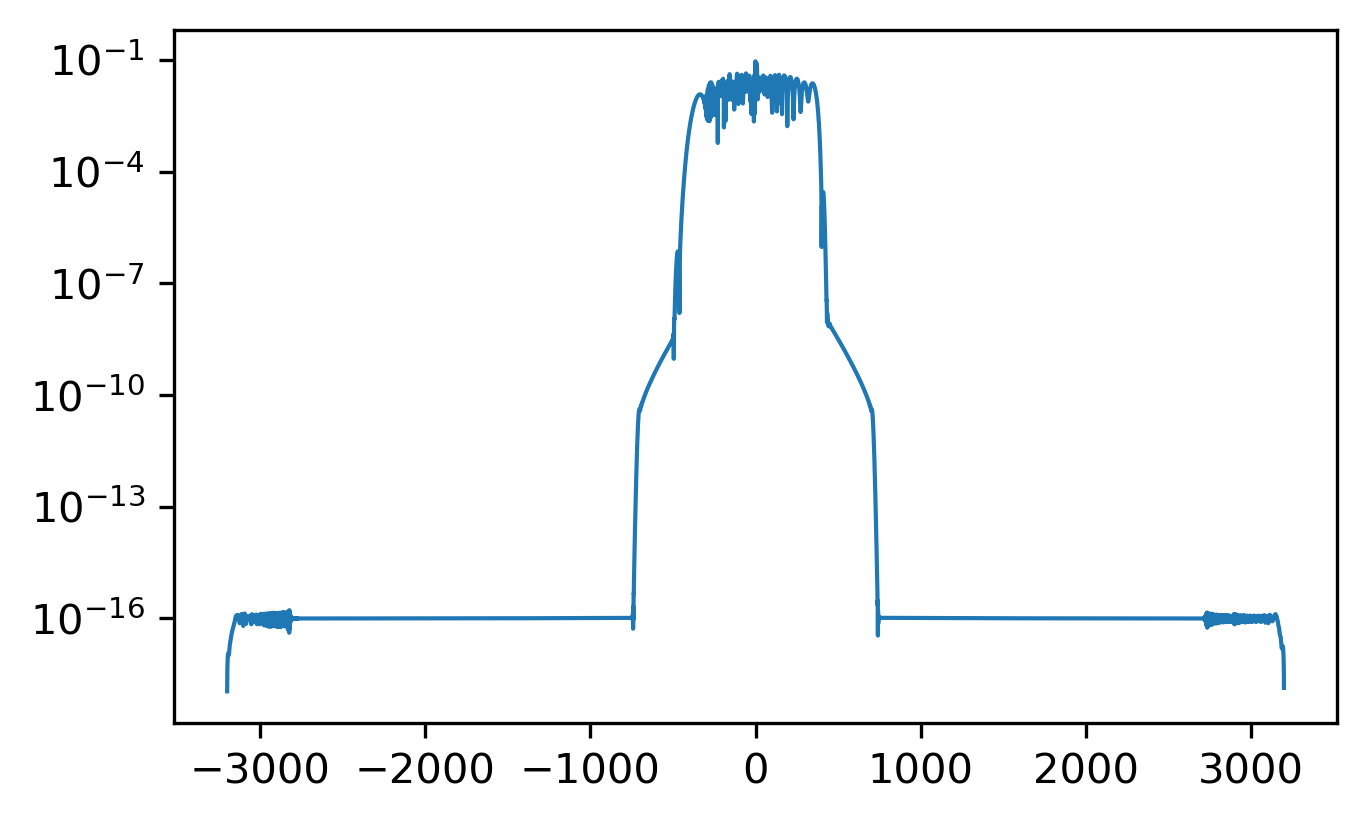

In [93]:
plot(inputs.get_xgrid(), np.abs(wavefunction[-1]), plot_scale="log", linewidth=1)